In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 626ms/step - loss: 0.1937
Average validation loss: 0.6329426169395447
4/4 [==============================] - 6s 642ms/step - loss: 0.1937 - val_loss: 0.6329
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 584ms/step - loss: 0.1465 - val_loss: 0.6329
Average validation loss: 0.5030841827392578
4/4 [==============================] - 8s 598ms/step - loss: 0.1465 - val_loss: 0.5680
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 591ms/step - loss: 0.1146 - val_loss: 0.5680
Average validation loss: 0.1811818927526474
4/4 [==============================] - 11s 605ms/step - loss: 0.1146 - val_loss: 0.4391
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\Ri

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 809ms/step - loss: 0.0127
Average validation loss: 7.42638912925031e-05
8/8 [==============================] - 7s 820ms/step - loss: 0.0127 - val_loss: 7.4264e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 777ms/step - loss: 0.0120 - val_loss: 7.4264e-05
Average validation loss: 6.352029686240712e-06
8/8 [==============================] - 13s 788ms/step - loss: 0.0120 - val_loss: 4.0308e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 20s 805ms/step - loss: 0.0122 - val_loss: 4.0308e-05
Average validation loss: 0.0
8/8 [==============================] - 20s 820ms/step - loss: 0.0122 - val_loss: 2.6872e-05
Saved model weights to 'c:\Users\user\Desktop\天_1

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 10s 794ms/step - loss: 0.0124
Average validation loss: 0.22253389159838358
12/12 [==============================] - 10s 807ms/step - loss: 0.0124 - val_loss: 0.2225
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 19s 804ms/step - loss: 0.0129 - val_loss: 0.2225
Average validation loss: 0.06245315478554403
12/12 [==============================] - 19s 817ms/step - loss: 0.0129 - val_loss: 0.1425
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 29s 775ms/step - loss: 0.0126 - val_loss: 0.1425
Average validation loss: 0.09657893173152843
12/12 [==============================] - 29s 787ms/step - loss: 0.0126 - val_loss: 0.1272
Epoch 4/10
12/12 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 734ms/step - loss: 0.0098
Average validation loss: 0.04410622169962153
16/16 [==============================] - 12s 745ms/step - loss: 0.0098 - val_loss: 0.0441
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 766ms/step - loss: 0.0096 - val_loss: 0.0441
Average validation loss: 0.053391520865261555
16/16 [==============================] - 24s 778ms/step - loss: 0.0096 - val_loss: 0.0487
Epoch 3/10
16/16 [==============================] - 36s 737ms/step - loss: 0.0092 - val_loss: 0.0487
Average validation loss: 0.011408310769184027
16/16 [==============================] - 37s 749ms/step - loss: 0.0092 - val_loss: 0.0363
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_20.pth'.
Epoch 4/10
16/16 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 749ms/step - loss: 0.0068
Average validation loss: 0.2749823868274689
20/20 [==============================] - 15s 763ms/step - loss: 0.0068 - val_loss: 0.2750
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 30s 708ms/step - loss: 0.0071 - val_loss: 0.2750
Average validation loss: 0.10069516586372629
20/20 [==============================] - 30s 722ms/step - loss: 0.0071 - val_loss: 0.1878
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 714ms/step - loss: 0.0068 - val_loss: 0.1878
Average validation loss: 0.02108407985069789
20/20 [==============================] - 45s 727ms/step - loss: 0.0068 - val_loss: 0.1323
Saved model weights to 'c:\Users\user\Deskt

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 725ms/step - loss: 0.0076
Average validation loss: 0.02350406503925721
24/24 [==============================] - 18s 738ms/step - loss: 0.0076 - val_loss: 0.0235
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 36s 749ms/step - loss: 0.0072 - val_loss: 0.0235
Average validation loss: 0.014463852780560652
24/24 [==============================] - 36s 760ms/step - loss: 0.0072 - val_loss: 0.0190
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 717ms/step - loss: 0.0065 - val_loss: 0.0190
Average validation loss: 0.016487411689013243
24/24 [==============================] - 54s 729ms/step - loss: 0.0065 - val_loss: 0.0182
Epoch 4/10
24/24 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 736ms/step - loss: 0.0117
Average validation loss: 0.03615410923957825
40/40 [==============================] - 30s 749ms/step - loss: 0.0117 - val_loss: 0.0362
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 719ms/step - loss: 0.0105 - val_loss: 0.0362
Average validation loss: 0.048999877739697696
40/40 [==============================] - 59s 730ms/step - loss: 0.0105 - val_loss: 0.0426
Epoch 3/10
40/40 [==============================] - 88s 717ms/step - loss: 0.0097 - val_loss: 0.0426
Average validation loss: 0.038992097973823546
40/40 [==============================] - 88s 729ms/step - loss: 0.0097 - val_loss: 0.0414
Epoch 4/10
40/40 [==============================] - 117s 719ms/step - loss: 0.0092 - val_loss: 0.0414
Average validation loss: 0.052924766577780245
40/40 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 723ms/step - loss: 0.0080
Average validation loss: 0.016039207805382222
48/48 [==============================] - 35s 734ms/step - loss: 0.0080 - val_loss: 0.0160
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 725ms/step - loss: 0.0067 - val_loss: 0.0160
Average validation loss: 0.014076420225440719
48/48 [==============================] - 71s 736ms/step - loss: 0.0067 - val_loss: 0.0151
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 106s 726ms/step - loss: 0.0059 - val_loss: 0.0151
Average validation loss: 0.011662001454775842
48/48 [==============================] - 106s 738ms/step - loss: 0.0059 - val_loss: 0.0139
Saved model weights to 'c:\Users\user

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 42s 742ms/step - loss: 0.0088
Average validation loss: 0.15614899363273643
56/56 [==============================] - 42s 753ms/step - loss: 0.0088 - val_loss: 0.1561
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 83s 720ms/step - loss: 0.0072 - val_loss: 0.1561
Average validation loss: 0.06919305027063924
56/56 [==============================] - 83s 731ms/step - loss: 0.0072 - val_loss: 0.1127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 124s 727ms/step - loss: 0.0063 - val_loss: 0.1127
Average validation loss: 0.018084927572528237
56/56 [==============================] - 125s 739ms/step - loss: 0.0063 - val_loss: 0.0811
Saved model weights to 'c:\Users\user\D

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 722ms/step - loss: 0.0062
Average validation loss: 0.010077831204398535
64/64 [==============================] - 47s 734ms/step - loss: 0.0062 - val_loss: 0.0101
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 717ms/step - loss: 0.0053 - val_loss: 0.0101
Average validation loss: 0.016327652788074687
64/64 [==============================] - 94s 728ms/step - loss: 0.0053 - val_loss: 0.0132
Epoch 3/10
64/64 [==============================] - 140s 717ms/step - loss: 0.0048 - val_loss: 0.0132
Average validation loss: 0.01199581675490724
64/64 [==============================] - 140s 729ms/step - loss: 0.0048 - val_loss: 0.0128
Epoch 4/10
64/64 [==============================] - 187s 735ms/step - loss: 0.0042 - val_loss: 0.0128
Average validation loss: 0.009244986484461037
64/64 [=======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 725ms/step - loss: 0.0062
Average validation loss: 0.012624421907174919
72/72 [==============================] - 53s 737ms/step - loss: 0.0062 - val_loss: 0.0126
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 106s 731ms/step - loss: 0.0049 - val_loss: 0.0126
Average validation loss: 0.010051113773240812
72/72 [==============================] - 107s 742ms/step - loss: 0.0049 - val_loss: 0.0113
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 159s 727ms/step - loss: 0.0043 - val_loss: 0.0113
Average validation loss: 0.009658401806114448
72/72 [==============================] - 160s 738ms/step - loss: 0.0043 - val_loss: 0.0108
Saved model weights to 'c:\Users\us

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 63s 787ms/step - loss: 0.0048
Average validation loss: 0.007099490519613028
80/80 [==============================] - 64s 800ms/step - loss: 0.0048 - val_loss: 0.0071
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 128s 793ms/step - loss: 0.0041 - val_loss: 0.0071
Average validation loss: 0.00748704596189782
80/80 [==============================] - 129s 806ms/step - loss: 0.0041 - val_loss: 0.0073
Epoch 3/10
80/80 [==============================] - 192s 791ms/step - loss: 0.0035 - val_loss: 0.0073
Average validation loss: 0.02330924596171826
80/80 [==============================] - 193s 803ms/step - loss: 0.0035 - val_loss: 0.0126
Epoch 4/10
80/80 [==============================] - 256s 792ms/step - loss: 0.0032 - val_loss: 0.0126
Average validation loss: 0.03803941518999636
80/80 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 70s 733ms/step - loss: 0.0073
Average validation loss: 0.02052003884455189
96/96 [==============================] - 72s 745ms/step - loss: 0.0073 - val_loss: 0.0205
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 141s 719ms/step - loss: 0.0059 - val_loss: 0.0205
Average validation loss: 0.025264022192762543
96/96 [==============================] - 142s 730ms/step - loss: 0.0059 - val_loss: 0.0229
Epoch 3/10
96/96 [==============================] - 210s 717ms/step - loss: 0.0051 - val_loss: 0.0229
Average validation loss: 0.028847089658180874
96/96 [==============================] - 212s 728ms/step - loss: 0.0051 - val_loss: 0.0249
Epoch 4/10
96/96 [==============================] - 280s 716ms/step - loss: 0.0045 - val_loss: 0.0249
Average validation loss: 0.03522715000084039
96/96 [=====================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 95s 790ms/step - loss: 0.0047
Average validation loss: 0.014071052824757164
120/120 [==============================] - 96s 803ms/step - loss: 0.0047 - val_loss: 0.0141
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 192s 793ms/step - loss: 0.0039 - val_loss: 0.0141
Average validation loss: 0.006310361627980636
120/120 [==============================] - 193s 806ms/step - loss: 0.0039 - val_loss: 0.0102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 288s 787ms/step - loss: 0.0037 - val_loss: 0.0102
Average validation loss: 0.013047548294263727
120/120 [==============================] - 289s 799ms/step - loss: 0.0037 - val_loss: 0.0111
Epoch 4/10
120/120 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 114s 791ms/step - loss: 0.0041
Average validation loss: 0.011493660658339245
144/144 [==============================] - 116s 804ms/step - loss: 0.0041 - val_loss: 0.0115
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 228s 780ms/step - loss: 0.0036 - val_loss: 0.0115
Average validation loss: 0.008531256719581708
144/144 [==============================] - 230s 792ms/step - loss: 0.0036 - val_loss: 0.0100
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 342s 781ms/step - loss: 0.0034 - val_loss: 0.0100
Average validation loss: 0.012209548763672097
144/144 [==============================] - 344s 793ms/step - loss: 0.0034 - val_loss: 0.0107
Epoch 4/10
144/144 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 717ms/step - loss: 0.0034
Average validation loss: 0.011786391785426531
160/160 [==============================] - 117s 728ms/step - loss: 0.0034 - val_loss: 0.0118
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 717ms/step - loss: 0.0027 - val_loss: 0.0118
Average validation loss: 0.007037385417061159
160/160 [==============================] - 233s 728ms/step - loss: 0.0027 - val_loss: 0.0094
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 718ms/step - loss: 0.0024 - val_loss: 0.0094
Average validation loss: 0.010777386039262638
160/160 [==============================] - 350s 730ms/step - loss: 0.0024 - val_loss: 0.0099
Epoch 4/10
160/160 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 715ms/step - loss: 0.0059
Average validation loss: 0.011793714598752558
200/200 [==============================] - 145s 726ms/step - loss: 0.0059 - val_loss: 0.0118
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 288s 715ms/step - loss: 0.0046 - val_loss: 0.0118
Average validation loss: 0.011744784789625555
200/200 [==============================] - 291s 726ms/step - loss: 0.0046 - val_loss: 0.0118
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 434s 716ms/step - loss: 0.0040 - val_loss: 0.0118
Average validation loss: 0.01124216447584331
200/200 [==============================] - 436s 728ms/step - loss: 0.0040 - val_loss: 0.0116
Saved model weights 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:59 - loss: 7.6203e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 719ms/step - loss: 0.0038
Average validation loss: 0.021399504016153516
240/240 [==============================] - 175s 730ms/step - loss: 0.0038 - val_loss: 0.0214
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 347s 716ms/step - loss: 0.0030 - val_loss: 0.0214
Average validation loss: 0.012598775016279736
240/240 [==============================] - 350s 728ms/step - loss: 0.0030 - val_loss: 0.0170
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_60\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 522s 717ms/step - loss: 0.0026 - val_loss: 0.0170
Average validation loss: 0.02196784512295077
240/240 [==============================] - 525s 729ms/step - loss: 0.0026 - val_loss: 0.0187
Epoch 4/10
240/240 [

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08700620292040895, 0.1559564380547531, 0.0957689583690697, 0.04537481479067063, 0.047583444404076664, 0.023425198139701658, 0.03609884341260305, 0.059834008168947767, 0.034838321808089684, 0.02380945085248709, 0.009080475587279153, 0.021935746219520737, 0.014999763217031878, 0.013172363950540862, 0.00995232762826316, 0.006671151668844687, 0.00958871696627466, 0.011771737561945104]
std_val_losses =  [0.1506910523739834, 0.17139306928825682, 0.08016769272621309, 0.03231514393054, 0.08353338271460921, 0.025838613656285765, 0.05401285573206107, 0.10993992538940005, 0.06830112967860734, 0.09085980892526162, 0.009703017887968382, 0.03609481856837062, 0.017447975296464167, 0.02493066329038725, 0.013137554928905674, 0.0040035813670943185, 0.00859366623660969, 0.013045849749975491]


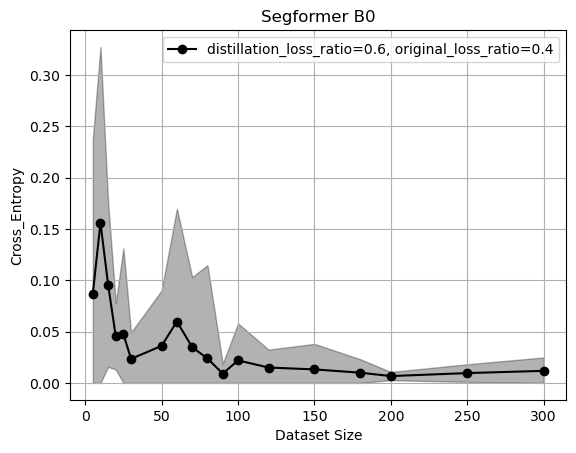

In [3]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()